In [1]:
import pandas as pd
import matplotlib.pyplot as plt
csv_path = "/kaggle/input/msadata/meme_data/labels.csv"
img_path = "/kaggle/input/msadata/meme_data/images/" 
df = pd.read_csv(csv_path)
df.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


In [2]:
print(df['humour'].value_counts())
print(df['sarcasm'].value_counts())
print(df['offensive'].value_counts())
print(df['motivational'].value_counts())
print(df['overall_sentiment'].value_counts()) 

humour
funny         2452
very_funny    2238
not_funny     1651
hilarious      651
Name: count, dtype: int64
sarcasm
general            3507
twisted_meaning    1547
not_sarcastic      1544
very_twisted        394
Name: count, dtype: int64
offensive
not_offensive        2713
slight               2592
very_offensive       1466
hateful_offensive     221
Name: count, dtype: int64
motivational
not_motivational    4525
motivational        2467
Name: count, dtype: int64
overall_sentiment
positive         3127
neutral          2201
very_positive    1033
negative          480
very_negative     151
Name: count, dtype: int64


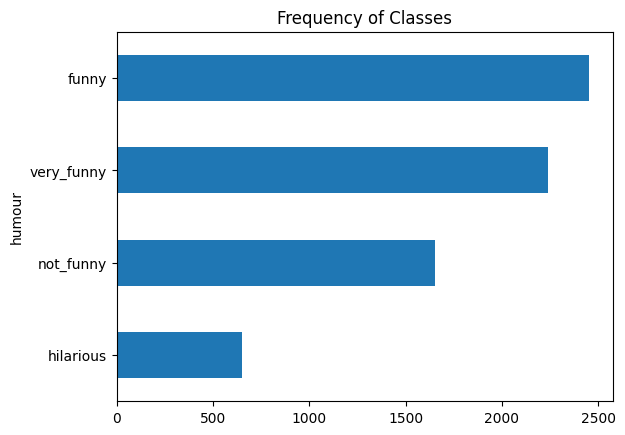

In [3]:
label_counts = df['humour'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

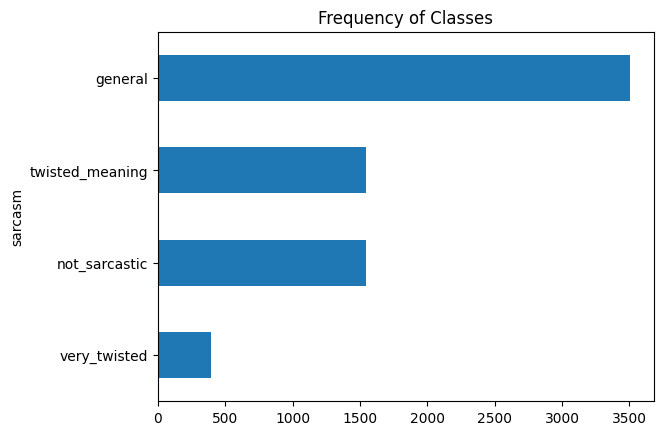

In [4]:
label_counts = df['sarcasm'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

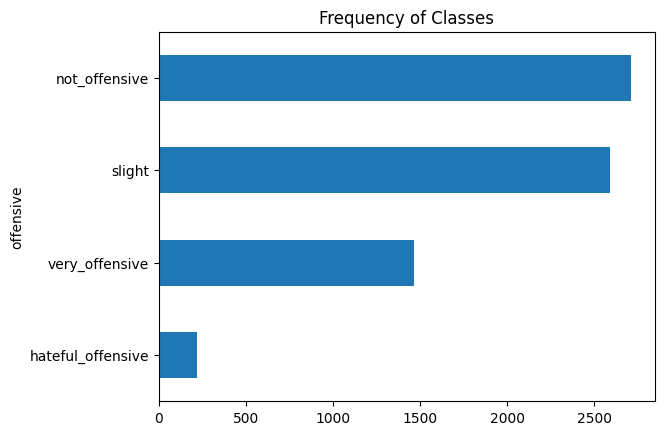

In [5]:
label_counts = df['offensive'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

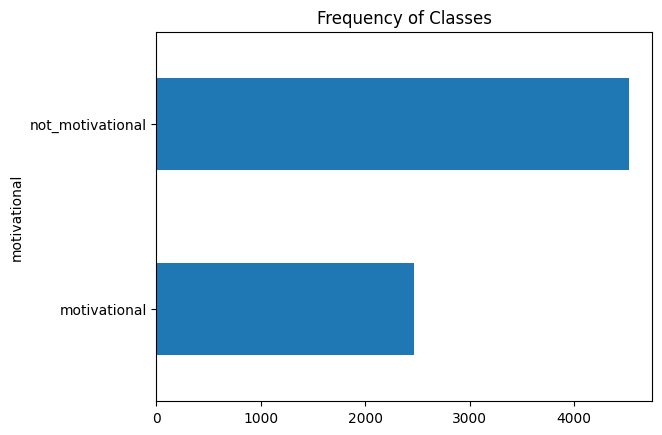

In [6]:
label_counts = df['motivational'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

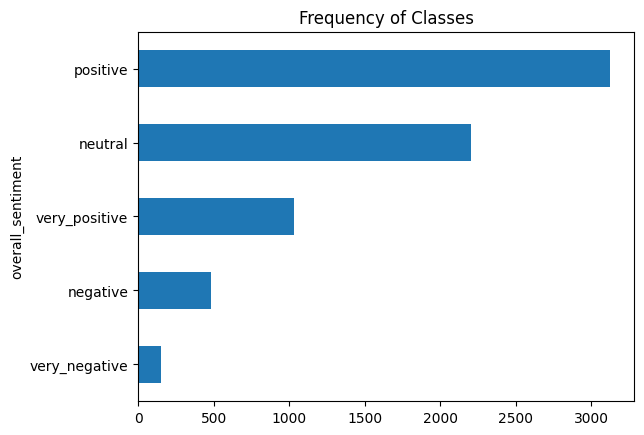

In [7]:
label_counts = df['overall_sentiment'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [8]:

H = {
    "hilarious": 3,
    "very_funny": 2,
    "funny": 1,
    "not_funny": 0
}
df["Humor_label"] = df["humour"].map(H).fillna(0).astype(int)


S = {
    "very_twisted": 3,
    "twisted_meaning": 2,
    "general": 1,
    "not_sarcastic": 0
}
df["Sarcasm_label"] = df["sarcasm"].map(S).fillna(0).astype(int)


O = {
    "hateful_offensive": 3,
    "very_offensive": 2,
    "slight": 1,
    "not_offensive": 0
    
}
df["Offensive_label"] = df["offensive"].map(O).fillna(0).astype(int)


sentiment_mapping = {
    "very_positive": 2, "positive": 2,
    "very_negative": 0, "negative": 0,
    "neutral":1
}
df["sentiment_label"] = df["overall_sentiment"].map(sentiment_mapping).fillna(0).astype(int)

df = df.reset_index(drop=True)

In [9]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image, UnidentifiedImageError

class MemeDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, tokenizer=None):
        self.data = df
        self.img_dir = img_dir
        self.transform = transform
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]['image_name'])

        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            image = torch.zeros((3, 224, 224))  # fallback if image fails to load

        text = str(self.data.iloc[idx]['text_corrected'])
        text_encoded = self.tokenizer(text, padding='max_length', truncation=True, max_length=256, return_tensors='pt')
        text_encoded = {k: v.squeeze(0) for k, v in text_encoded.items()}  # remove batch dim

        # Labels as tensors
        sentiment = torch.tensor(int(self.data.iloc[idx]['sentiment_label']), dtype=torch.long)
        humor     = torch.tensor(int(self.data.iloc[idx]['Humor_label']), dtype=torch.long)
        sarcasm   = torch.tensor(int(self.data.iloc[idx]['Sarcasm_label']), dtype=torch.long)
        offense   = torch.tensor(int(self.data.iloc[idx]['Offensive_label']), dtype=torch.long)

        return {
            'image': image,
            'text': text_encoded,
            'sentiment_label': sentiment,
            'humor_label': humor,
            'sarcasm_label': sarcasm,
            'offense_label': offense,
        }

In [10]:
import torchvision.transforms as transforms
from transformers import ViTModel, BertModel, ViTFeatureExtractor, BertTokenizer

vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [11]:
pip install iterative-stratification

Note: you may need to restart the kernel to use updated packages.


In [12]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

label_cols = ["Humor_label", "Sarcasm_label", "Offensive_label", "sentiment_label"]
y = df[label_cols].values  

mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx, test_idx = next(mskf.split(df, y))

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df = df.iloc[test_idx].reset_index(drop=True)

train_dataset = MemeDataset(train_df, img_path, transform=transform, tokenizer=bert_tokenizer)
test_dataset = MemeDataset(test_df, img_path, transform=transform, tokenizer=bert_tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

In [13]:
import torch
import torch.nn as nn
from transformers import ViTModel, BertModel

class CrossAttentionBlock(nn.Module):
    def __init__(self, dim_q, dim_kv, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim_q, kdim=dim_kv, vdim=dim_kv, num_heads=num_heads, batch_first=True)
    
    def forward(self, query, key_value):
        out, _ = self.attn(query, key_value, key_value)
        return out

class MemeCrossAttentionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.cross_attn_img_to_txt = CrossAttentionBlock(dim_q=768, dim_kv=768)
        self.cross_attn_txt_to_img = CrossAttentionBlock(dim_q=768, dim_kv=768)

        self.classifier_input_dim = 768 * 2 
        self.sentiment_classifier = nn.Sequential(
            nn.Linear(self.classifier_input_dim, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 3)  # Output: 3 sentiment classes
        )
        
        self.humor_classifier = nn.Sequential(
            nn.Linear(self.classifier_input_dim, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)  # Output: 4 humor classes
        )
        
        self.sarcasm_classifier = nn.Sequential(
            nn.Linear(self.classifier_input_dim, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)  # Output: 4 sarcasm classes
        )
        
        self.offense_classifier = nn.Sequential(
            nn.Linear(self.classifier_input_dim, 256),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)  # Output: 4 offense classes
        )

    def forward(self, image, text):
        vit_out = self.vit(pixel_values=image).last_hidden_state      
        bert_out = self.bert(**text).last_hidden_state                

        img_cls = vit_out[:, 0:1, :]      
        text_cls = bert_out[:, 0:1, :]    

        img_attn = self.cross_attn_img_to_txt(img_cls, bert_out)  
        text_attn = self.cross_attn_txt_to_img(text_cls, vit_out)  

        combined = torch.cat([img_attn.squeeze(1), text_attn.squeeze(1)], dim=-1)  

        return {
            'sentiment_logits': self.sentiment_classifier(combined),
            'humor_logits': self.humor_classifier(combined),
            'sarcasm_logits': self.sarcasm_classifier(combined),
            'offense_logits': self.offense_classifier(combined),
        }


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple GPU)")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

model = MemeCrossAttentionClassifier().to(device)

for name, param in model.named_parameters():
    if 'bert' in name or 'vit' in name:
        param.requires_grad = False

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

ce_loss = nn.CrossEntropyLoss()
num_epochs = 8
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        images = batch['image'].to(device)
        text_input = {k: v.to(device) for k, v in batch['text'].items()}

        outputs = model(images, text_input)

        loss_sentiment = ce_loss(outputs['sentiment_logits'], batch['sentiment_label'].to(device))
        loss_humor     = ce_loss(outputs['humor_logits'],     batch['humor_label'].to(device))
        loss_sarcasm   = ce_loss(outputs['sarcasm_logits'],   batch['sarcasm_label'].to(device))
        loss_offense   = ce_loss(outputs['offense_logits'],   batch['offense_label'].to(device))

        loss = loss_sentiment + loss_humor + loss_sarcasm + loss_offense
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"[Epoch {epoch+1}] Avg Train Loss: {avg_train_loss:.4f}")

    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            text_input = {k: v.to(device) for k, v in batch['text'].items()}

            outputs = model(images, text_input)

            val_loss_sentiment = ce_loss(outputs['sentiment_logits'], batch['sentiment_label'].to(device))
            val_loss_humor     = ce_loss(outputs['humor_logits'],     batch['humor_label'].to(device))
            val_loss_sarcasm   = ce_loss(outputs['sarcasm_logits'],   batch['sarcasm_label'].to(device))
            val_loss_offense   = ce_loss(outputs['offense_logits'],   batch['offense_label'].to(device))

            total_val_loss += (val_loss_sentiment + val_loss_humor + val_loss_sarcasm + val_loss_offense).item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"[Epoch {epoch+1}] Avg Validation Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

Using device: cuda


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[Epoch 1] Avg Train Loss: 4.6610
[Epoch 1] Avg Validation Loss: 4.5454
[Epoch 2] Avg Train Loss: 4.5569
[Epoch 2] Avg Validation Loss: 4.5471
[Epoch 3] Avg Train Loss: 4.5340
[Epoch 3] Avg Validation Loss: 4.5569
[Epoch 4] Avg Train Loss: 4.5046
[Epoch 4] Avg Validation Loss: 4.5896
[Epoch 5] Avg Train Loss: 4.4648
[Epoch 5] Avg Validation Loss: 4.5978
[Epoch 6] Avg Train Loss: 4.3883
[Epoch 6] Avg Validation Loss: 4.6052
[Epoch 7] Avg Train Loss: 4.3612
[Epoch 7] Avg Validation Loss: 4.6198
[Epoch 8] Avg Train Loss: 4.3443
[Epoch 8] Avg Validation Loss: 4.6292


In [15]:
torch.save(model.state_dict(), "meme_classifier_final.pth")

In [16]:
from sklearn.metrics import accuracy_score

model.eval()

all_preds = {
    'sentiment': [],
    'humor': [],
    'sarcasm': [],
    'offense': []
}
all_targets = {
    'sentiment': [],
    'humor': [],
    'sarcasm': [],
    'offense': []
}

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        text_input = {k: v.to(device) for k, v in batch['text'].items()}

        outputs = model(images, text_input)

        preds_sentiment = torch.argmax(outputs['sentiment_logits'], dim=1).cpu().tolist()
        preds_humor     = torch.argmax(outputs['humor_logits'], dim=1).cpu().tolist()
        preds_sarcasm   = torch.argmax(outputs['sarcasm_logits'], dim=1).cpu().tolist()
        preds_offense   = torch.argmax(outputs['offense_logits'], dim=1).cpu().tolist()

        labels_sentiment = batch['sentiment_label'].cpu().tolist()
        labels_humor     = batch['humor_label'].cpu().tolist()
        labels_sarcasm   = batch['sarcasm_label'].cpu().tolist()
        labels_offense   = batch['offense_label'].cpu().tolist()

        all_preds['sentiment'].extend(preds_sentiment)
        all_preds['humor'].extend(preds_humor)
        all_preds['sarcasm'].extend(preds_sarcasm)
        all_preds['offense'].extend(preds_offense)

        all_targets['sentiment'].extend(labels_sentiment)
        all_targets['humor'].extend(labels_humor)
        all_targets['sarcasm'].extend(labels_sarcasm)
        all_targets['offense'].extend(labels_offense)

print("\nFinal Accuracy Scores on Validation Data:")
for task in ['sentiment', 'humor', 'sarcasm', 'offense']:
    score = accuracy_score(all_targets[task], all_preds[task])
    print(f"{task.capitalize()}: {score:.4f}")


Final Accuracy Scores on Validation Data:
Sentiment: 0.5898
Humor: 0.3393
Sarcasm: 0.4896
Offense: 0.3744
